Compiling model...
Building feed-forward neural network...
'build' took 0.051776 s


Generating sparse fractional matrix...
Generating sparse fractional matrix...
'compile' took 14.895130 s

Training model...

Step      Train loss              Test loss               Test metric
0         [1.19e+01, 2.78e+01]    [1.19e+01, 0.00e+00]    []  
0 [1.50e+00]
500 [1.05e+00]
1000      [1.14e+01, 3.55e-02]    [1.14e+01, 0.00e+00]    []  
1000 [9.40e-01]
1500 [9.25e-01]
2000      [1.14e+01, 1.52e-02]    [1.14e+01, 0.00e+00]    []  
2000 [9.25e-01]
2500 [9.26e-01]
3000      [1.14e+01, 9.38e-03]    [1.14e+01, 0.00e+00]    []  
3000 [9.26e-01]
3500 [9.26e-01]
4000      [1.14e+01, 7.32e-03]    [1.14e+01, 0.00e+00]    []  
4000 [9.26e-01]
4500 [9.26e-01]
5000      [1.14e+01, 6.22e-03]    [1.14e+01, 0.00e+00]    []  
5000 [9.26e-01]
5500 [9.25e-01]
6000      [1.14e+01, 6.45e-03]    [1.14e+01, 0.00e+00]    []  
6000 [9.24e-01]
6500 [9.23e-01]
7000      [1.14e+01, 6.77e-03]    [1.14e+01, 0.00e+00]    [

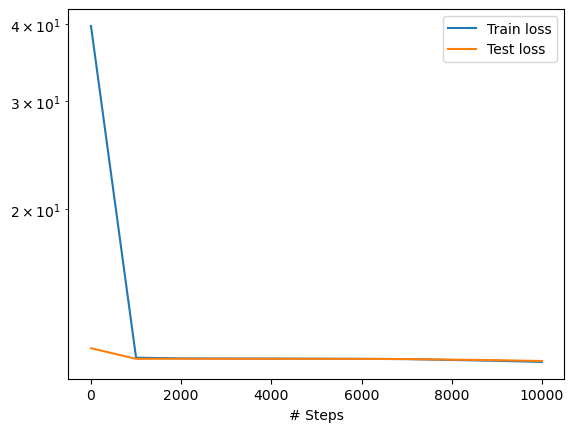

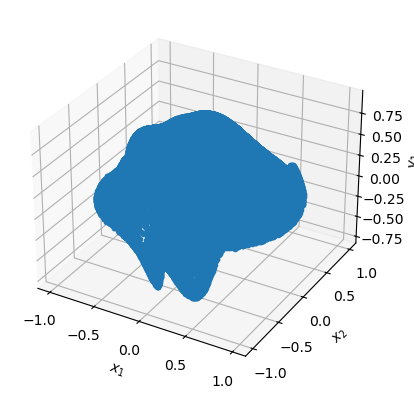

In [ ]:
# Fractioanl Laplacian Operator With Rotational Invariant 
# Backend selection: tensorflow.compat.v1
import os
os.environ['DDE_BACKEND'] = 'tensorflow.compat.v1'
# Import Library
import deepxde as dde
import numpy as np
import tensorflow as tf
from deepxde.backend import tf
from scipy.special import gamma

# Reverse learning variable definition with its guess value 
alpha = dde.Variable(1.5)

# Reverse learning variable actual value  
alpha0 = 1.8




# FPDE definition
# The following calculation includes the fractional Laplacian approximation at left-hand side equation based on sparse or dense matrix.
# Readers don't need to undersand the derivation process and the approximation theory. But it is a great example to show that 
# the PDE definition is testing user's knowledge on it's derivation. Without understanding the derivation but simply insert the PDE form will
# create fetal errors.  
def fpde(x, y, int_mat): # x is coordinate [x,y]. y is output u(x,y)
    # The equation to be solved
    r"""\int_theta D_theta^alpha u(x)"""
    # Check is the original matrix (int_mat) a sparse or dense matrix to applying one of the following approximation methods
    # If it's a sparse matrix
    if isinstance(int_mat, (list, tuple)) and len(int_mat) == 3:
        int_mat = tf.SparseTensor(*int_mat)
        # Approximate the solution based on the sparse matrix
        lhs = tf.sparse_tensor_dense_matmul(int_mat, y)
    else: # if it's a dense matrix 
        lhs = tf.matmul(int_mat, y)
        lhs = lhs[:, 0]
        lhs *= -tf.exp(tf.lgamma((1 - alpha) / 2) + tf.lgamma((2 + alpha) / 2)) / (2 * np.pi ** 1.5)
    x = x[: tf.size(lhs)]
    # Analytical solution
    rhs = (2 ** alpha0* gamma(2 + alpha0 / 2)* gamma(1 + alpha0 / 2)* (1 - (1 + alpha0 / 2) * tf.reduce_sum(x ** 2, axis=1)))
    # Return the equilibrium as shown in section 3.6
    return lhs - rhs

# Solutions for y at x
def func(x):
    return (1 - np.linalg.norm(x, axis=1, keepdims=True) ** 2) ** (1 + alpha0 / 2)

# Geometry domain in a disk where origin at [0,0] and radius is 1 
geom = dde.geometry.Disk([0, 0], 1)
# Point-wise boundary conditions
observe_x = geom.random_points(30)
observe_y = dde.icbc.PointSetBC(observe_x, func(observe_x))

#Data Compile 
data = dde.data.FPDE(
    geom,
    fpde,
    alpha,              # Learning Variable
    observe_y,          # Point-wise BC
    [8, 100],           # Direction numbers (8) and quadrature points per direction (100) 
                        # Here it cuts 360 digree into 8 with each 45 degree. Each direction has 100 quadrature points.
    num_domain=64,
    anchors=observe_x,  # Define specific sampling locations
    solution=func,      # Define solution for those specified sampling locations
)

#network structure
net = dde.nn.FNN([2] + [20] * 4 + [1], "tanh", "Glorot normal")

# Apply a strong boundary condition by mutipling the output with equation (1-||x||**2). When x is at the boundary, the outut will be 0 because (1-||x||**2) =0
net.apply_output_transform(lambda x, y: (1 - tf.reduce_sum(x ** 2, axis=1, keepdims=True)) * y)

#Model compile
model = dde.Model(data, net)
model.compile("adam", lr=1e-3, loss_weights=[1, 100], external_trainable_variables=[alpha])
#Show the alpha ervry 500 iterations
variable = dde.callbacks.VariableValue(alpha, period=500)
# Model training 
losshistory, train_state = model.train(iterations=1000, callbacks=[variable]) #Increase iteration for better result. I set it low to test.
dde.saveplot(losshistory, train_state, issave=True, isplot=True)